# Deterministic forecasting of the silver price using ARIMA method

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
# Get silver price df and set date as index
df_ag = pd.read_csv("../data/AG.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Preparing the time series to fit the ARIMA models

### Resample to weekly prices

In [4]:
# Resample to weekly prices (taking the mean of the week)
df_ag = df_ag.resample("W").mean()
df_ag = df_ag.asfreq("W")
# Front fill missing values
df_ag.ffill(inplace=True)

In [5]:
# Convert data type to more memory-efficient
df_ag = df_ag.astype({"price": "float32"})

### Split data into train and test

In [6]:
# Split the data into train and test sets based on date
split_date = pd.Timestamp("2022-01-01")
df_ag_train = df_ag.loc[df_ag.index < split_date].copy()
df_ag_test = df_ag.loc[df_ag.index >= split_date].copy()

In [7]:
# Check for missing values
print(df_ag_train.isnull().sum())
print(df_ag_test.isnull().sum())

price    0
dtype: int64
price    0
dtype: int64


### Check if the time series is stationary

<Axes: xlabel='date'>

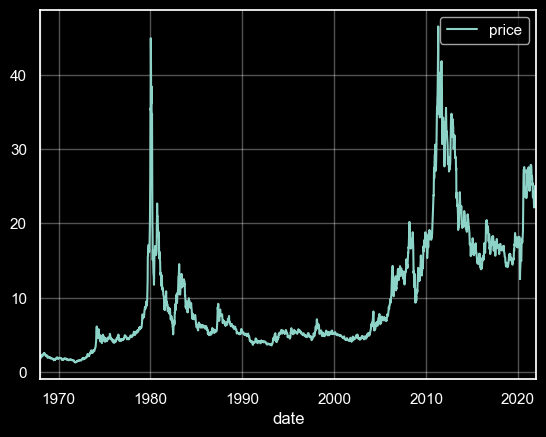

In [8]:
# Plot the df
df_ag_train.plot()

The plot clearly shows an upward trend, indicating the series is not stationary. Let's confirm this with other methods.

#### Autocorrelation function (ACF) and partial autocorrelation function (PACF)

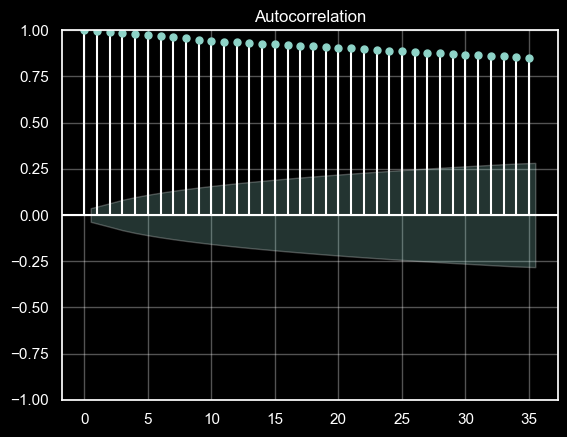

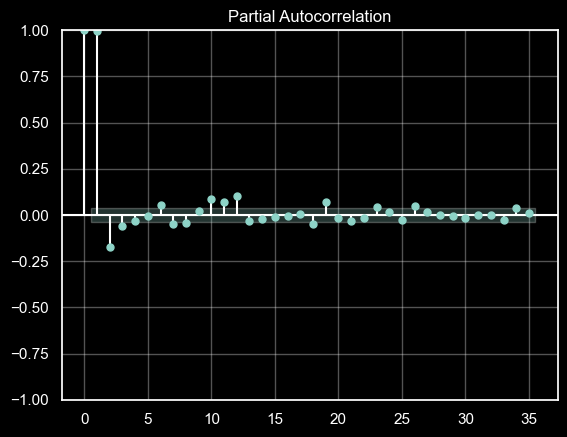

In [9]:
# Plot the acf and pacf
acf = plot_acf(df_ag_train)
pacf = plot_pacf(df_ag_train)

- The autocorrelation function (ACF) plot shows that the correlations decline slowly, indicating a strong and persistent correlation over time. This slow decay suggests that the time series data is non-stationary.
- The partial autocorrelation function (PACF) plot reveals that only the lag 1 value is significantly different from zero, indicating a strong correlation at lag 1 but not beyond. This pattern is typical of an autoregressive process.
- Together, these observations suggest that the time series data is non-stationary and shows a high degree of autocorrelation.

#### Augmented Dickey–Fuller (ADF) test

In [10]:
# Perform ADF test
adf_test  = adfuller(df_ag_train)
print(f"p-value: {adf_test[1]}")

p-value: 0.3885401449080233


- The ADF test results in a p-value close to 0.4, which is greater than the 0.05 threshold.
- A high p-value indicates that we fail to reject the null hypothesis of the ADF test, which states that the time series has a unit root (non-stationary)

### Transform time series into stationary using differencing

In [11]:
# Create diff from df
df_ag_train_diff = df_ag_train.diff().dropna()

### Check again for stationarity and determine ARIMA parameters

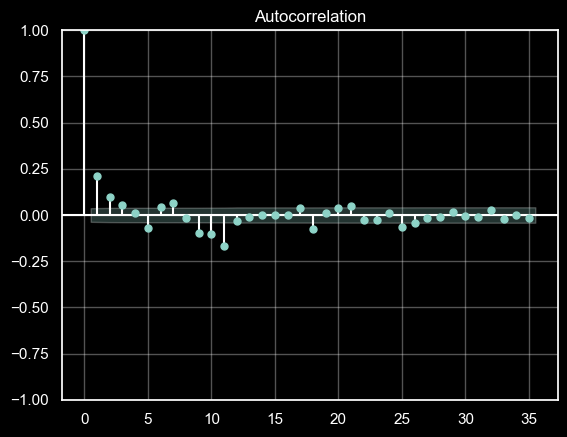

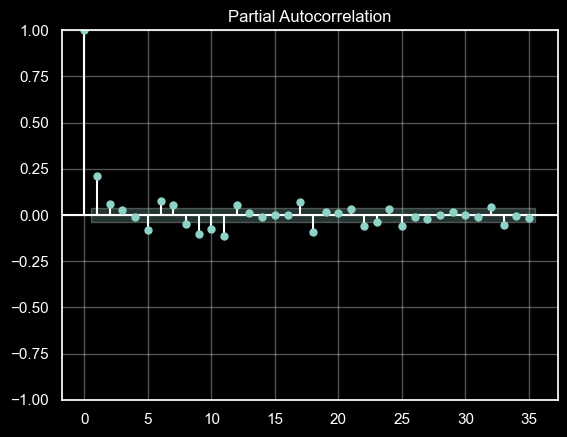

In [12]:
# Plot the acf and pacf
acf = plot_acf(df_ag_train_diff)
pacf = plot_pacf(df_ag_train_diff)

In [13]:
# Perform ADF test
adf_test  = adfuller(df_ag_train_diff)
print(f"p-value: {adf_test[1]}")

p-value: 7.47350030323111e-23


- After differencing, we can conclude that the time series is stationary with "d" = 1.
- Based on the ACF and PACF plots, "q" is 3 and "p" is 2.
- Let's use the pmdarima module to obtain the "auto" parameters.

### Determine the ARIMA parameters using pmdarima

In [14]:
# Shorten the train df to avoid huge RAM consumption
df_ag_train_short = df_ag_train["1980":]
model_auto = pm.auto_arima(df_ag_train_short, seasonal=True, m=52, trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=4335.397, Time=34.92 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=4431.306, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=4358.666, Time=5.05 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=4350.756, Time=5.89 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=4429.476, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=4333.590, Time=22.93 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=4332.279, Time=0.60 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=4333.571, Time=22.55 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=4350.233, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=4350.185, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[52] intercept   : AIC=4311.488, Time=1.15 sec
 ARIMA(3,1,2)(1,0,0)[52] intercept   : AIC=4313.354, Time=44.10 sec
 ARIMA(3,1,2)(0,0,1)[52] intercept   : AIC=4313.361, Time=39.13 sec
 ARIMA(3,1,2)(1,0,1)[52] intercept   : AIC=4315.369, Time=46.42 sec
 ARIMA(3,1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2191
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -2144.612
Date:                Fri, 21 Jun 2024   AIC                           4303.225
Time:                        20:41:55   BIC                           4343.066
Sample:                    01-06-1980   HQIC                          4317.786
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5189      0.012    -43.651      0.000      -0.542      -0.496
ar.L2         -0.8334      0.009    -94.346      0.000      -0.851      -0.816
ar.L3          0.1858      0.008     22.460      0.000       0.170       0.202
ar.L4          0.0163      0.009      1.846      0.065      -0.001       0.034
ma.L1          0.7293      0.010     73.715      0.000       0.710       0.749
ma.L2          0.9149      0.007    128.203      0.000       0.901       0.929
sigma2         0.4149      0.003    142.788      0.000       0.409       0.421
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            193594.00
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit the ARIMA models

### Train the ARIMA models

#### Manual model

In [15]:
manual_model = ARIMA(df_ag_train, order=(2, 1, 3))
manual_model_fit = manual_model.fit()
manual_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2817
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2579.349
Date:                Fri, 21 Jun 2024   AIC                           5170.697
Time:                        20:41:55   BIC                           5206.356
Sample:                    01-07-1968   HQIC                          5183.565
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4493      0.030     15.184      0.000       0.391       0.507
ar.L2         -0.6774      0.023    -29.022      0.000      -0.723      -0.632
ma.L1         -0.2596      0.029     -8.841      0.000      -0.317      -0.202
ma.L2          0.6955      0.020     34.204      0.000       0.656       0.735
ma.L3          0.1737      0.006     28.091      0.000       0.162       0.186
sigma2         0.3657      0.002    181.244      0.000       0.362       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            452862.06
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.79
Prob(H) (two-sided):                  0.06   Kurtosis:                        65.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto model

In [16]:
# Auto model is seasonal
auto_model = ARIMA(df_ag_train, order=model_auto.order, seasonal_order=model_auto.seasonal_order)
auto_model_fit = auto_model.fit()
auto_model_fit.summary()

/home/tm/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tm/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2817
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2578.441
Date:                Fri, 21 Jun 2024   AIC                           5170.883
Time:                        20:41:57   BIC                           5212.484
Sample:                    01-07-1968   HQIC                          5185.895
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6190      0.025     24.688      0.000       0.570       0.668
ar.L2         -0.8360      0.025    -33.944      0.000      -0.884      -0.788
ar.L3          0.1910      0.006     30.796      0.000       0.179       0.203
ar.L4         -0.0250      0.005     -4.608      0.000      -0.036      -0.014
ma.L1         -0.4253      0.025    -17.359      0.000      -0.473      -0.377
ma.L2          0.8205      0.022     36.669      0.000       0.777       0.864
sigma2         0.3654      0.002    177.736      0.000       0.361       0.369
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            448570.10
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.81
Prob(H) (two-sided):                  0.06   Kurtosis:                        64.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check models residuals

#### Manual model

<Axes: title={'center': 'Density'}, ylabel='Density'>

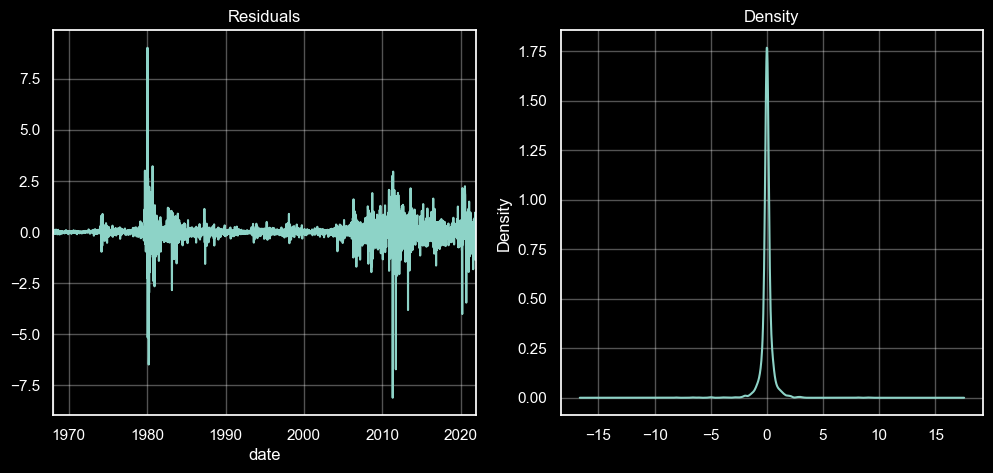

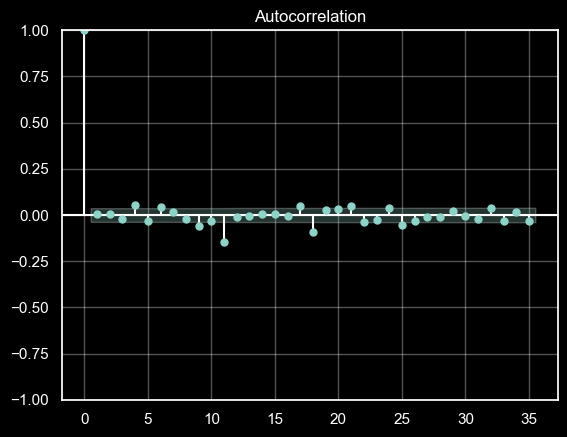

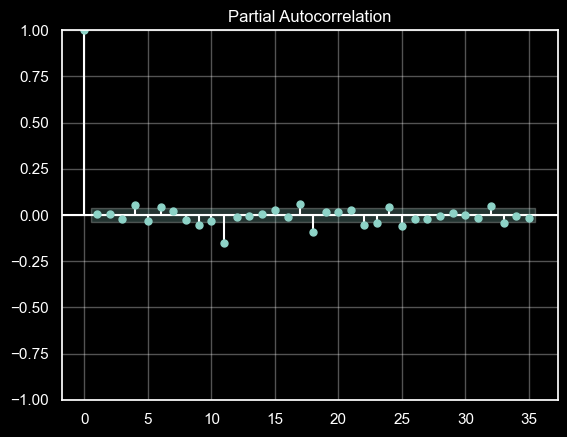

In [17]:
residuals = manual_model_fit.resid[1:]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(residuals)
plot_pacf(residuals)
residuals.plot(title="Residuals", ax=axes[0])
residuals.plot(title="Density", ax=axes[1], kind="kde")

#### Auto model

<Axes: title={'center': 'Density'}, ylabel='Density'>

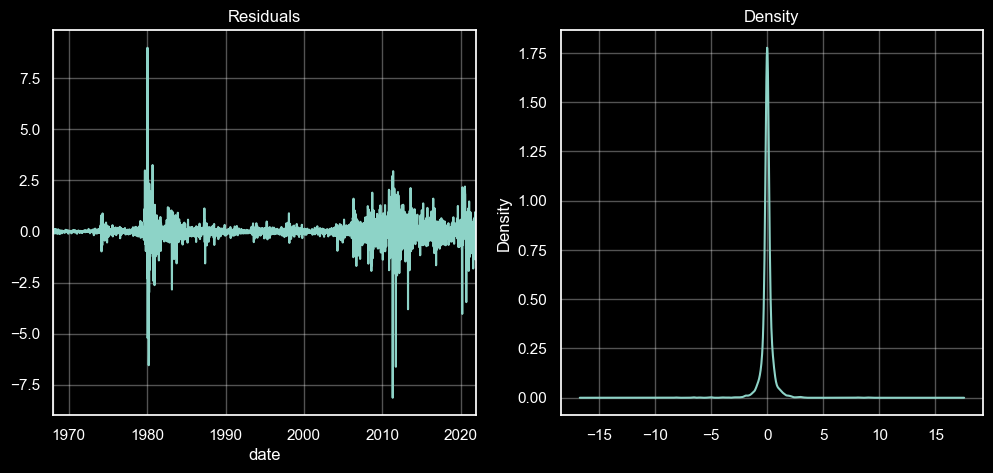

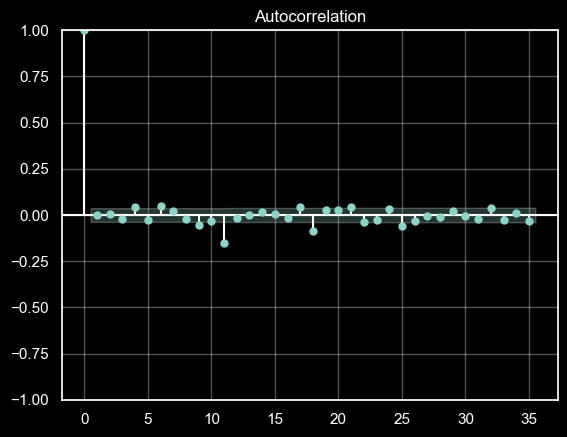

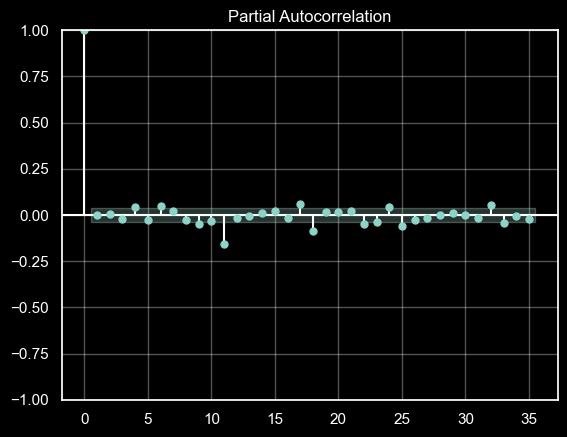

In [18]:
residuals = auto_model_fit.resid[1:]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(residuals)
plot_pacf(residuals)
residuals.plot(title="Residuals", ax=axes[0])
residuals.plot(title="Density", ax=axes[1], kind="kde")

- Residuals resemble white noise in both models.
- Their density is normally distributed.
- ACF and PACF plots show no significant spikes for both models.
- Therefore, the models appear to be well-fitted and meet the necessary diagnostic criteria.

### Forecast on the training data

In [19]:
# Get number of periods to forecast from test
n_forecast = len(df_ag_test)

#### Manual model

In [20]:
# Get forecast values
manual_forecast = manual_model_fit.get_forecast(steps=n_forecast)
manual_forecast_values = manual_forecast.predicted_mean
manual_conf_int = manual_forecast.conf_int()

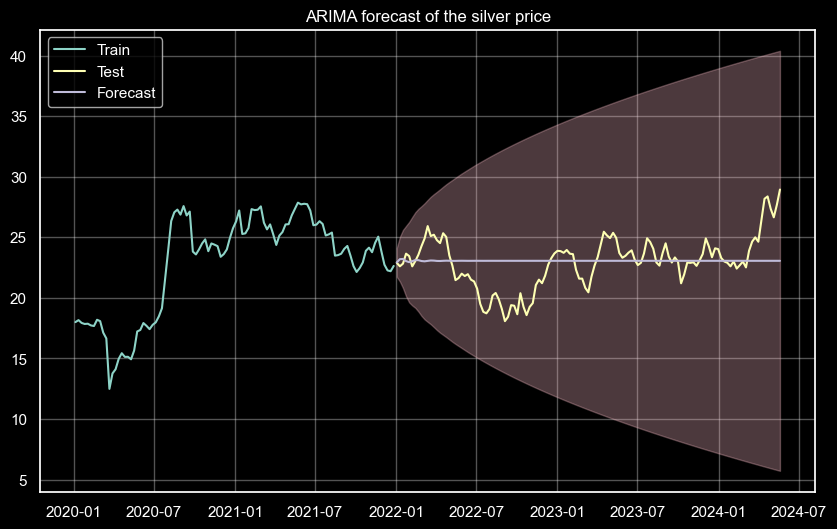

In [21]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_ag_train.loc["2020-01-01":].index, df_ag_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_ag_test.loc["2020-01-01":].index, df_ag_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_ag_test.loc["2020-01-01":].index, manual_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_ag_test.loc["2020-01-01":].index, manual_conf_int.iloc[:, 0], manual_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("ARIMA forecast of the silver price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

#### Auto model

In [22]:
# Get forecast values
auto_forecast = auto_model_fit.get_forecast(steps=n_forecast)
auto_forecast_values = auto_forecast.predicted_mean
auto_conf_int = auto_forecast.conf_int()

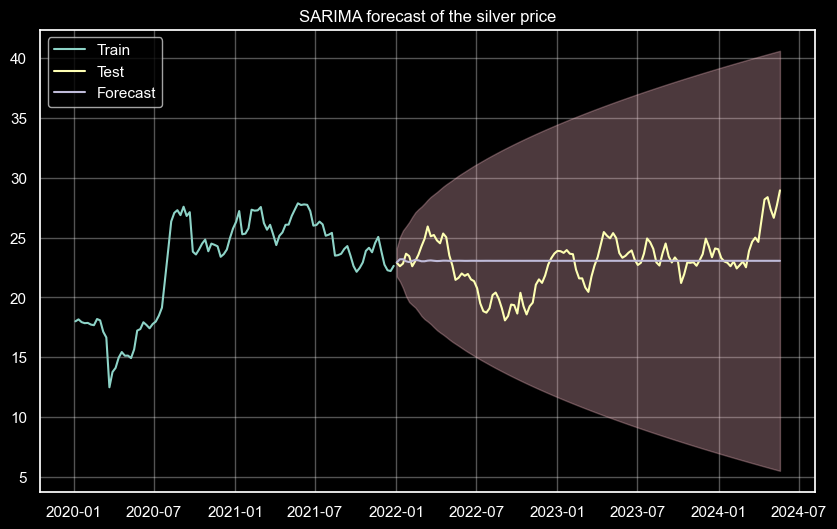

In [23]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_ag_train.loc["2020-01-01":].index, df_ag_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_ag_test.loc["2020-01-01":].index, df_ag_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_ag_test.loc["2020-01-01":].index, auto_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_ag_test.loc["2020-01-01":].index, auto_conf_int.iloc[:, 0], auto_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("SARIMA forecast of the silver price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

### Evaluate both models

#### Manual model

In [24]:
# Evaluate model
mae = mean_absolute_error(df_ag_test, manual_forecast_values)
rmse = np.sqrt(mean_squared_error(df_ag_test, manual_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.5896277154168992
RMSE: 2.1356731426093454


#### Auto model

In [25]:
# Evaluate model
mae = mean_absolute_error(df_ag_test, auto_forecast_values)
rmse = np.sqrt(mean_squared_error(df_ag_test, auto_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.5899169296855227
RMSE: 2.1354464879485078


**Both models seem to be accurate. The manual model is slightly more. Let's also try a fine tuned.**

### Fine tune a model

In [26]:
# Fit tuned model (the exact same parameters of gold are also the best for silver)
tuned_model = ARIMA(df_ag_train, order=(3, 1, 0), seasonal_order=(0, 1, 1, 52))
tuned_model_fit = tuned_model.fit()
tuned_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2817
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 52)   Log Likelihood               -2659.547
Date:                            Fri, 21 Jun 2024   AIC                           5329.093
Time:                                    20:43:45   BIC                           5358.715
Sample:                                01-07-1968   HQIC                          5339.793
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1929      0.005     40.438      0.000       0.184       0.202
ar.L2          0.0562      0.004     14.125      0.000       0.048       0.064
ar.L3          0.0275      0.005      5.139      0.000       0.017       0.038
ma.S.L52      -0.9764      0.013    -77.428      0.000      -1.001      -0.952
sigma2         0.3792      0.004    100.057      0.000       0.372       0.387
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            394010.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -1.20
Prob(H) (two-sided):                  0.06   Kurtosis:                        61.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Get forecast values
tuned_forecast = tuned_model_fit.get_forecast(steps=n_forecast)
tuned_forecast_values = tuned_forecast.predicted_mean
tuned_conf_int = tuned_forecast.conf_int()

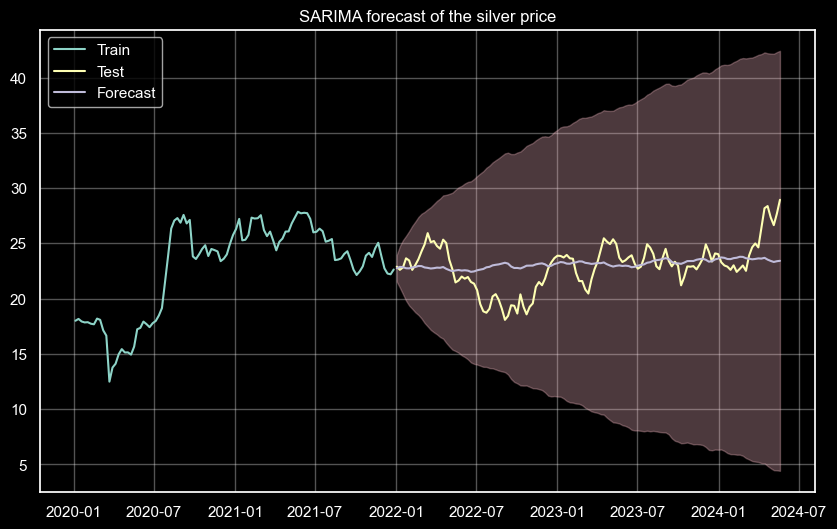

In [28]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_ag_train.loc["2020-01-01":].index, df_ag_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_ag_test.loc["2020-01-01":].index, df_ag_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_ag_test.loc["2020-01-01":].index, tuned_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_ag_test.loc["2020-01-01":].index, tuned_conf_int.iloc[:, 0], tuned_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("SARIMA forecast of the silver price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

In [29]:
# Evaluate model
mae = mean_absolute_error(df_ag_test, tuned_forecast_values)
rmse = np.sqrt(mean_squared_error(df_ag_test, tuned_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.5539507160676809
RMSE: 2.0574974703351177


**This model has provided better results. Just like gold's, this one is the best performing. Therefore it'll be used for the forecast.**

## The forecast

In [30]:
# Fit model
model = ARIMA(df_ag, order=(3, 1, 0), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2942
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 52)   Log Likelihood               -2803.351
Date:                            Fri, 21 Jun 2024   AIC                           5616.703
Time:                                    20:45:45   BIC                           5646.546
Sample:                                01-07-1968   HQIC                          5627.458
                                     - 05-19-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1990      0.005     41.032      0.000       0.190       0.209
ar.L2          0.0377      0.004      9.202      0.000       0.030       0.046
ar.L3          0.0286      0.005      5.264      0.000       0.018       0.039
ma.S.L52      -0.9805      0.014    -71.849      0.000      -1.007      -0.954
sigma2         0.3853      0.004     89.107      0.000       0.377       0.394
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            358493.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Get number of periods (weeks) to forecast
n_forecast = 26

In [32]:
# Get forecast values
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()
forecast_index = pd.date_range(start=df_ag.index[-1], periods=n_forecast + 1, freq="W")[1:]

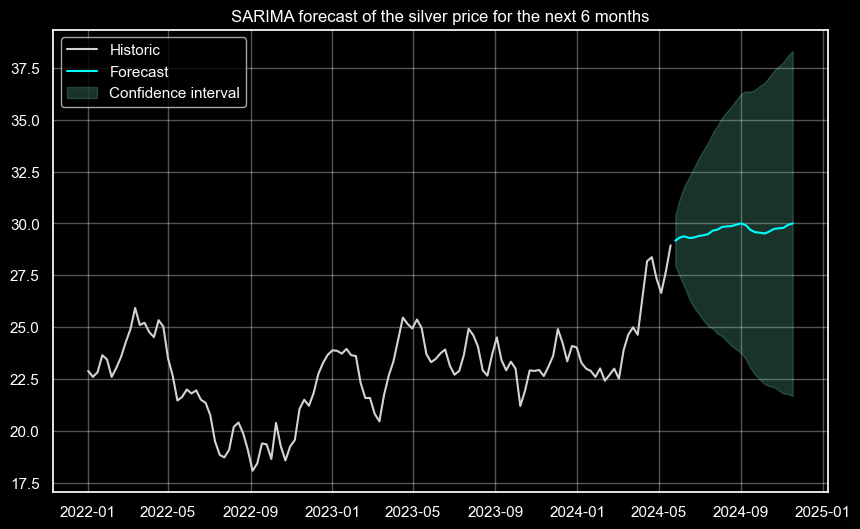

In [33]:
plt.figure(figsize=(10, 6))

# Plot the original data
sns.lineplot(x=df_ag.loc["2022-01-01":].index, y=df_ag.loc["2022-01-01":]["price"], label="Historic", color="lightgrey")

# Plot the forecast data
sns.lineplot(x=forecast_index, y=forecast_values, label="Forecast", color="aqua")

# Fill the confidence interval
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], label="Confidence interval", color="aquamarine", alpha=0.2)

plt.title("SARIMA forecast of the silver price for the next 6 months")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

save_chart_as_png("7.2_AG_ARIMA")

**Silver prices are expected to rise steadily over the next six months, much like gold. Although the model parameters are the same to those used for gold, the confidence interval for silver is significantly wider.**